In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from scipy.stats import f_oneway, ttest_ind
import statsmodels.stats.multicomp as mc

# to read data from a google sheets
from google.colab import auth
import gspread
from google.auth import default

# authenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# 1. Load Data

These 2 functions will:
1. Load Data from a Google Sheets URL and a Sheet Name
2. Transform data into datetime and numerical types so the dataframe is ready to analyze

In [ ]:
def load_data(url, sheet_name):

    # Opening the Google Sheets document
    sh = gc.open_by_url(url)

    # Selecting the first sheet
    worksheet = sh.get_worksheet(0)

    if sheet_name:
        worksheet = sh.worksheet(sheet_name)
    else:
        worksheet = sh.get_worksheet(0)

    # Getting all values from the sheet
    data = worksheet.get_all_values()

    # Converting to DataFrame
    df = pd.DataFrame(data[1:], columns=data[0])

    # Drop columns
    df = df.drop(columns={
    'Temperature', 'Wind Speed', 'Wind Direction','Barometer','Visibility'
})

    # Rename columns
    df = df.rename(columns={
        'Date': 'date',
        'Time':'time',
        'Weather':'weather',
        'Humidity':'humidity',
        'temperature_celcius':'temperature_celsius'
    })

    return df

In [ ]:
def transform_data_types(df):

    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Convert 'time' column to datetime
    # df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time

    # Convert 'temperature_celsius' to float
    df['temperature_celsius'] = pd.to_numeric(df['temperature_celsius'], errors='coerce')

    # Convert 'wind_speed_km' to float after removing commas
    df['wind_speed_km'] = pd.to_numeric(df['wind_speed_km'], errors='coerce')

    # Convert 'humidity' to integer
    df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

    # Convert 'barometer_mbar' to integer
    df['barometer_mbar'] = pd.to_numeric(df['barometer_mbar'].str.replace(',', ''), errors='coerce')

    # Convert 'visibility' to integer
    df['visibility'] = pd.to_numeric(df['visibility'], errors='coerce')

    return df

Call functions to Load and Transform data types

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1VLpfUc1_7fO3XSv7_3HCaMqveRFSrvjmom5lqvz2JZs/edit#gid=877692951'
sheet_name = 'data_limpia'

df = load_data(url, sheet_name) # call load data function
df = transform_data_types(df) # call transform data function
df.head()

,date,time,temperature_celsius,weather,wind_speed_km,wind__direction,humidity,barometer_mbar,visibility
0,2009-01-01,0:00,22,Clear.,26.0,,0.73,1020.0,16.0
1,2009-01-02,0:00,22,Clear.,26.0,,0.73,1020.0,16.0
2,2009-01-03,0:00,22,Clear.,26.0,,0.73,1020.0,16.0
3,2009-01-04,0:00,22,Clear.,26.0,,0.73,1020.0,16.0
4,2009-01-05,0:00,22,Clear.,26.0,,0.73,1020.0,16.0


# 2. Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122256 entries, 0 to 122255
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 122256 non-null  datetime64[ns]
 1   time                 122256 non-null  object        
 2   temperature_celsius  122256 non-null  int64         
 3   weather              122256 non-null  object        
 4   wind_speed_km        120029 non-null  float64       
 5   wind__direction      122256 non-null  object        
 6   humidity             122225 non-null  float64       
 7   barometer_mbar       122194 non-null  float64       
 8   visibility           69840 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 8.4+ MB


In [ ]:
df.describe()

,temperature_celsius,wind_speed_km,humidity,barometer_mbar,visibility
count,122256.000000,120029.000000,122225.000000,122194.000000,69840.000000
mean,18.070344,15.639062,0.710797,1015.922468,12.977821
std,5.734145,8.034220,0.155445,6.189654,5.077654
min,4.000000,0.000000,0.190000,997.000000,0.000000
25%,14.000000,9.000000,0.610000,1012.000000,9.000000
50%,18.000000,15.000000,0.730000,1016.000000,16.000000
75%,22.000000,20.000000,0.830000,1020.000000,16.000000
max,35.000000,48.000000,1.000000,1035.000000,16.000000


In [ ]:
df.isnull().sum()

date                       0
time                       0
temperature_celsius        0
weather                    0
wind_speed_km           2227
wind__direction            0
humidity                  31
barometer_mbar            62
visibility             52416
dtype: int64

In [ ]:
df_2022 = df[pd.to_datetime(df['date']).dt.year == 2022].copy()
df_2022.isnull().sum()

date                      0
time                      0
temperature_celsius       0
weather                   0
wind_speed_km           181
wind__direction           0
humidity                  0
barometer_mbar            0
visibility             4002
dtype: int64

In [ ]:
corr_matrix = df.corr(numeric_only=True)

In [ ]:
print(corr_matrix)

                     temperature_celsius  wind_speed_km  humidity  \
temperature_celsius             1.000000       0.055275 -0.242932   
wind_speed_km                   0.055275       1.000000 -0.039467   
humidity                       -0.242932      -0.039467  1.000000   
barometer_mbar                 -0.512915       0.103464 -0.134563   
visibility                      0.266585       0.057714 -0.585548   

                     barometer_mbar  visibility  
temperature_celsius       -0.512915    0.266585  
wind_speed_km              0.103464    0.057714  
humidity                  -0.134563   -0.585548  
barometer_mbar             1.000000    0.151460  
visibility                 0.151460    1.000000  


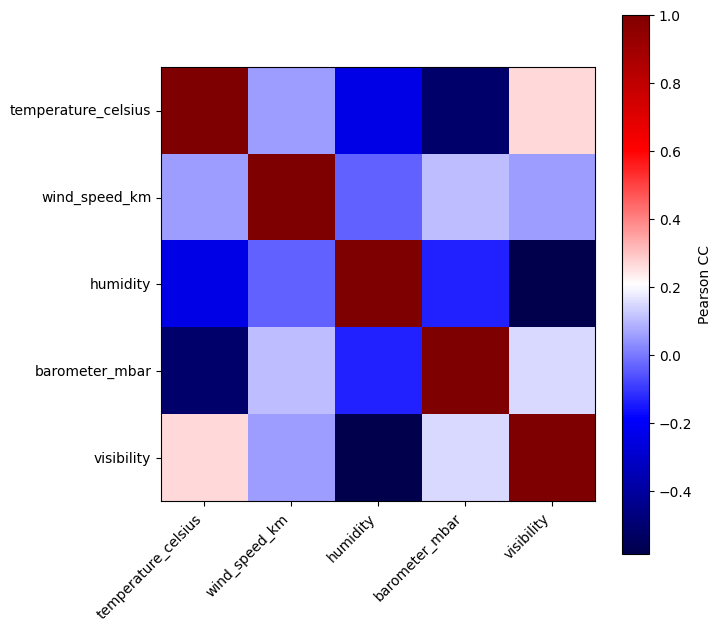

In [ ]:
plt.figure(figsize=(7, 7))
plt.imshow(corr_matrix, cmap="seismic")

# Define labels for X and Y axes using only the 5 columns included in the correlation matrix
xt = plt.xticks(np.arange(corr_matrix.shape[1]), corr_matrix.columns, rotation=45, ha='right', va='top')
yt = plt.yticks(np.arange(corr_matrix.shape[0]), corr_matrix.columns, rotation=0, ha='right', va='center')

# Define the color bar
plt.colorbar(label='Pearson CC')
plt.show()


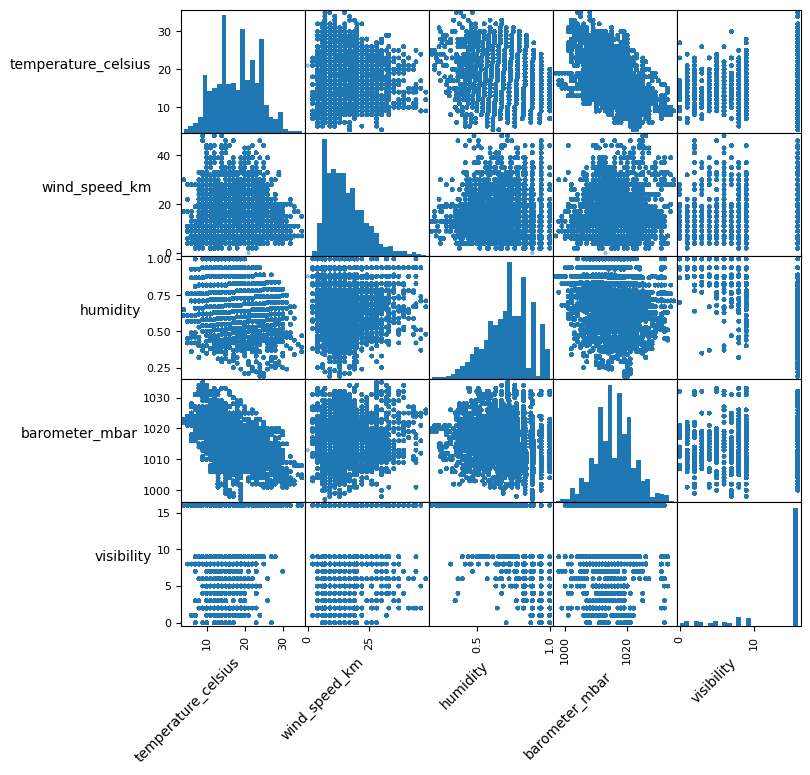

In [ ]:
axes = pd.plotting.scatter_matrix(df, figsize=(8, 8), alpha=0.5, hist_kwds={'bins': 25})

# Roto las etiquetas (puramente estético)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.xaxis.label.set_ha('right')
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

# Some Questions to Answer

1. How does humidity vary throughout the year, and are there any notable spikes or dips?
2. What are the typical wind speeds during different weather conditions, and how do they compare to calm periods?
3. Is there a pattern in barometric pressure changes over time, and are there any extreme fluctuations?
4. Are there any trends in temperature changes over the years, and are there periods of unusually high or low temperatures?

# A. How does humidity vary throughout the year, and are there any notable spikes or dips?

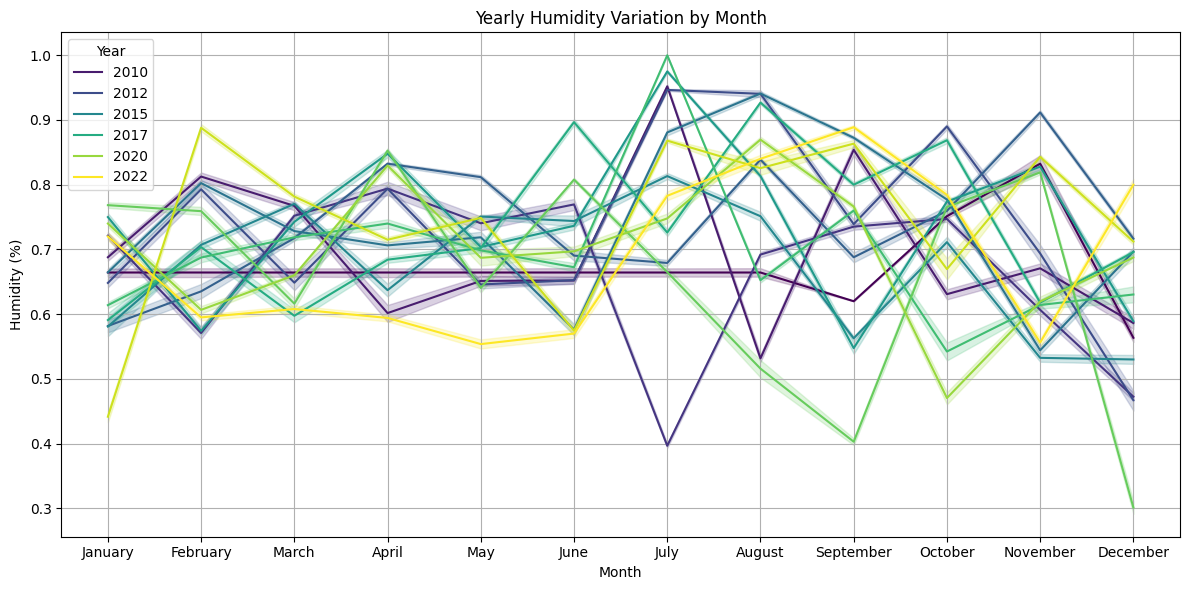

In [ ]:
# Plot the data using Seaborn's lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df['date'].dt.month, y='humidity', hue=df['date'].dt.year, palette='viridis', dashes=False)
plt.title('Yearly Humidity Variation by Month')
plt.xlabel('Month')
plt.ylabel('Humidity (%)')

# Customize x-axis ticks to display month names
plt.xticks(range(1, 13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

# Adjust x-axis limits to provide more space between the data points
plt.xlim(0.5, 12.5)

plt.grid(True)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate summary statistics for humidity variation by month
humidity_summary = df.groupby(df['date'].dt.month)['humidity'].agg(['count', 'mean', 'median', 'min', 'max', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])

# Rename the lambda functions for quartiles
humidity_summary.rename(columns={'<lambda_0>': 'q1', '<lambda_1>': 'q3'}, inplace=True)

# Add a column for the interquartile range (IQR)
humidity_summary['iqr'] = humidity_summary['q3'] - humidity_summary['q1']

print(humidity_summary)

      count      mean  median   min   max       std    q1    q3   iqr
date                                                                 
1     10447  0.655341   0.680  0.24  0.94  0.136177  0.59  0.75  0.16
2      9592  0.705697   0.700  0.36  1.00  0.138935  0.61  0.83  0.22
3     10230  0.697939   0.730  0.34  0.94  0.108549  0.64  0.78  0.14
4     10140  0.736095   0.740  0.37  1.00  0.130132  0.65  0.83  0.18
5     10447  0.694510   0.690  0.40  0.94  0.114888  0.63  0.77  0.14
6      9900  0.697091   0.685  0.35  1.00  0.131375  0.59  0.78  0.19
7     11222  0.805304   0.820  0.32  1.00  0.171264  0.71  0.94  0.23
8     10509  0.775664   0.820  0.25  1.00  0.163435  0.67  0.88  0.21
9      9450  0.733460   0.770  0.29  1.00  0.160208  0.64  0.88  0.24
10    10664  0.730000   0.770  0.27  1.00  0.160644  0.67  0.83  0.16
11     9270  0.682880   0.680  0.37  1.00  0.152949  0.56  0.83  0.27
12    10354  0.605210   0.640  0.19  1.00  0.172506  0.48  0.73  0.25


In [ ]:
# Calculate peak humidity
peak_humidity = df['humidity'].max()

# Find the month with the peak humidity
peak_month = df[df['humidity'] == peak_humidity]['date'].dt.month.unique()[0]

# Calculate lowest humidity
lowest_humidity = df['humidity'].min()

# Find the month with the lowest humidity
lowest_month = df[df['humidity'] == lowest_humidity]['date'].dt.month.unique()[0]

# Calculate average humidity
average_humidity = df['humidity'].mean()

# Print narrative analysis for humidity
print("The humidity tends to reach its peak around {} with a maximum value of {:.2f}%.".format(calendar.month_name[peak_month], peak_humidity))
print("The lowest humidity is typically observed in {} with a minimum value of {:.2f}%.".format(calendar.month_name[lowest_month], lowest_humidity))
print("On average, the humidity across all months is {:.2f}%.".format(average_humidity))

The humidity tends to reach its peak around September with a maximum value of 1.00%.
The lowest humidity is typically observed in December with a minimum value of 0.19%.
On average, the humidity across all months is 0.71%.


# B. How does the mean wind speed vary across different weather conditions, and are there any weather conditions associated with higher or lower wind speeds?

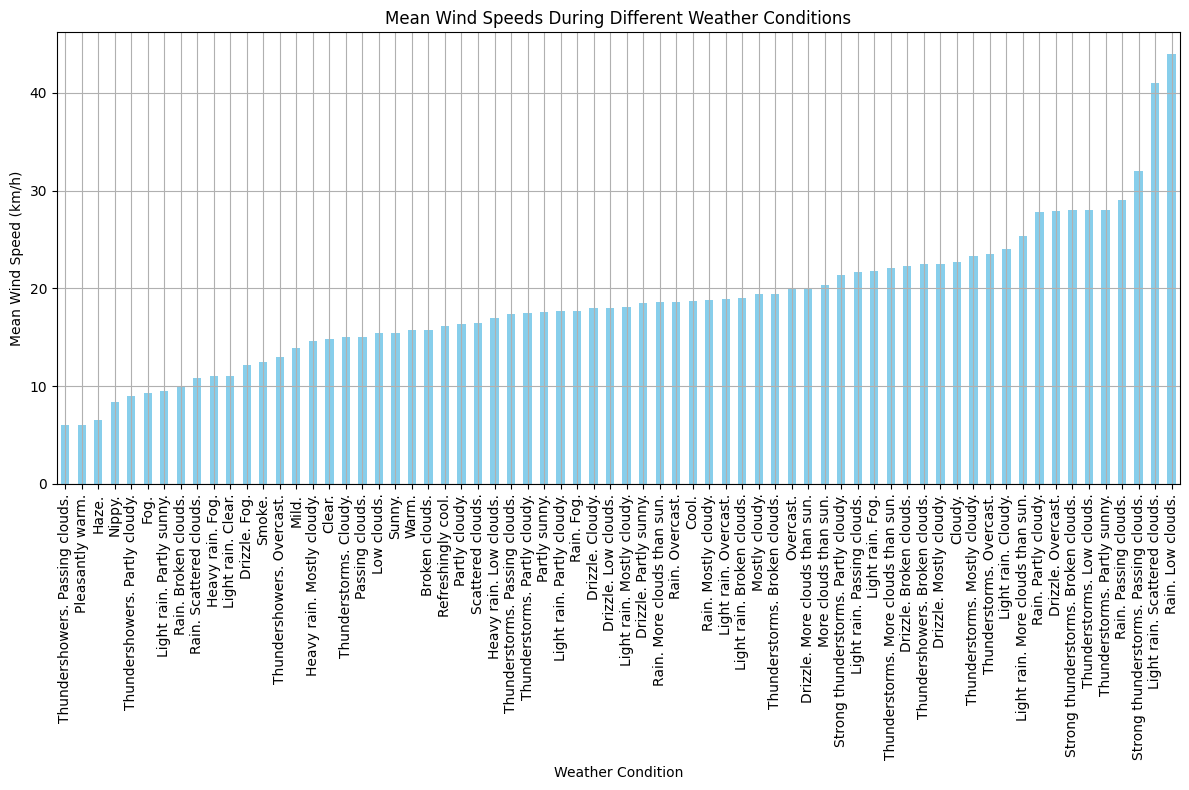

In [ ]:
# Calculate the mean wind speed for each weather condition
mean_wind_speeds = df.groupby('weather')['wind_speed_km'].mean().sort_values()

# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Plot bar plot of mean wind speeds for each weather condition
mean_wind_speeds.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Weather Condition')
plt.ylabel('Mean Wind Speed (km/h)')
plt.title('Mean Wind Speeds During Different Weather Conditions')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Calculate summary statistics for wind speed during different weather conditions
weather_summary = df.groupby('weather')['wind_speed_km'].agg(['count', 'mean', 'median', 'min', 'max', 'std'])

print("Summary Statistics for Wind Speed During Different Weather Conditions:")
print(weather_summary)

Summary Statistics for Wind Speed During Different Weather Conditions:
                                       count       mean  median   min   max  \
weather                                                                       
Broken clouds.                          3038  15.789335    15.0   4.0  46.0   
Clear.                                 30875  14.856518    13.0   0.0  46.0   
Cloudy.                                  122  22.680328    23.0  13.0  32.0   
Cool.                                   1069  18.664172    19.0   6.0  44.0   
Drizzle. Broken clouds.                  152  22.263158    19.0  17.0  30.0   
Drizzle. Cloudy.                          93  18.000000    17.0  15.0  22.0   
Drizzle. Fog.                            491  12.205703     9.0   7.0  19.0   
Drizzle. Low clouds.                     366  18.010929    16.0   9.0  37.0   
Drizzle. More clouds than sun.            60  20.000000    20.0   7.0  33.0   
Drizzle. Mostly cloudy.                  323  22.510836    1

<ipython-input-20-be873acbcb34>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='weather', y='wind_speed_km', palette='viridis')


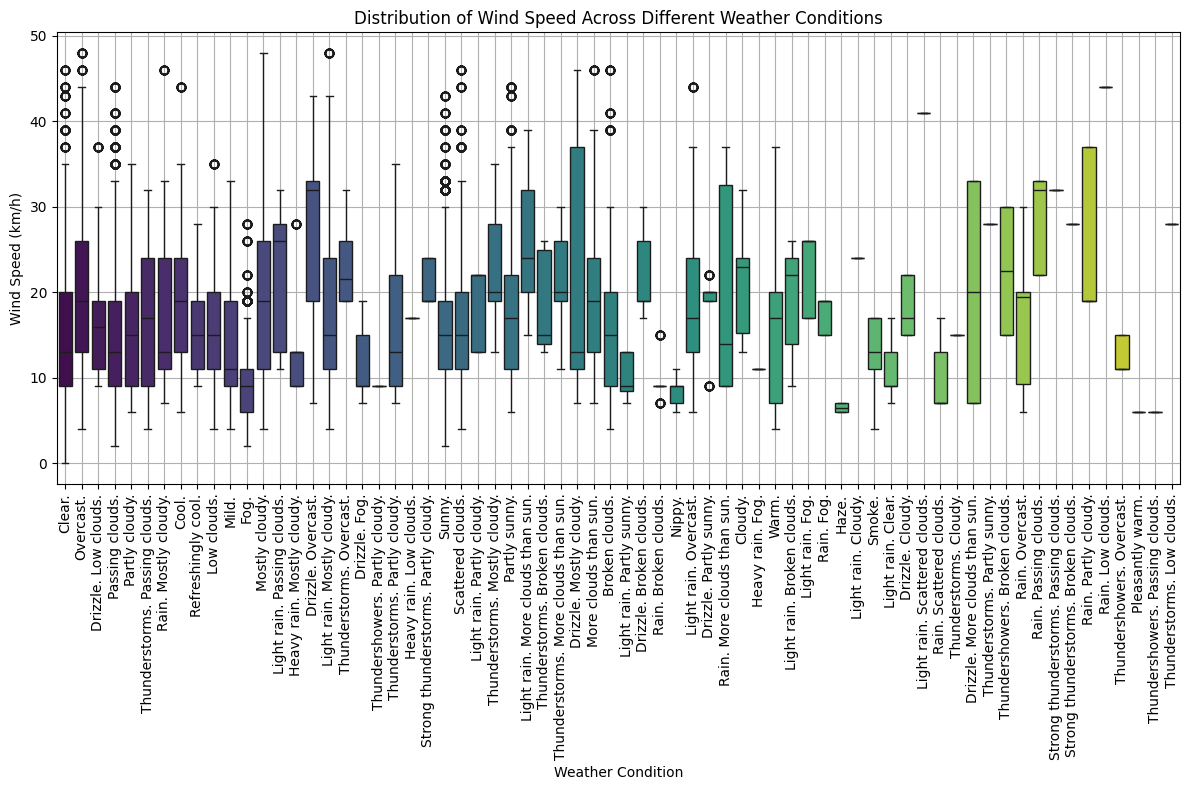

ANOVA Results:
F-statistic: nan
p-value: nan


In [ ]:
# Boxplot Visualization
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='weather', y='wind_speed_km', palette='viridis')
plt.title('Distribution of Wind Speed Across Different Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Wind Speed (km/h)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistical Tests
# Perform ANOVA to test for differences in mean wind speed among different weather conditions
anova_results = f_oneway(*[group['wind_speed_km'] for name, group in df.groupby('weather')])
print("ANOVA Results:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

# Post-hoc Analysis (Tukey's HSD test) if ANOVA indicates significant differences
if anova_results.pvalue < 0.05:
    posthoc = mc.MultiComparison(df['wind_speed_km'], df['weather'])
    tukey_results = posthoc.tukeyhsd()
    print("\nTukey's HSD Test Results:")
    print(tukey_results)

# C. How do rainy days vary across different months, seasons and years, and are there any noticeable patterns or trends in the frequency of rainy days over time?

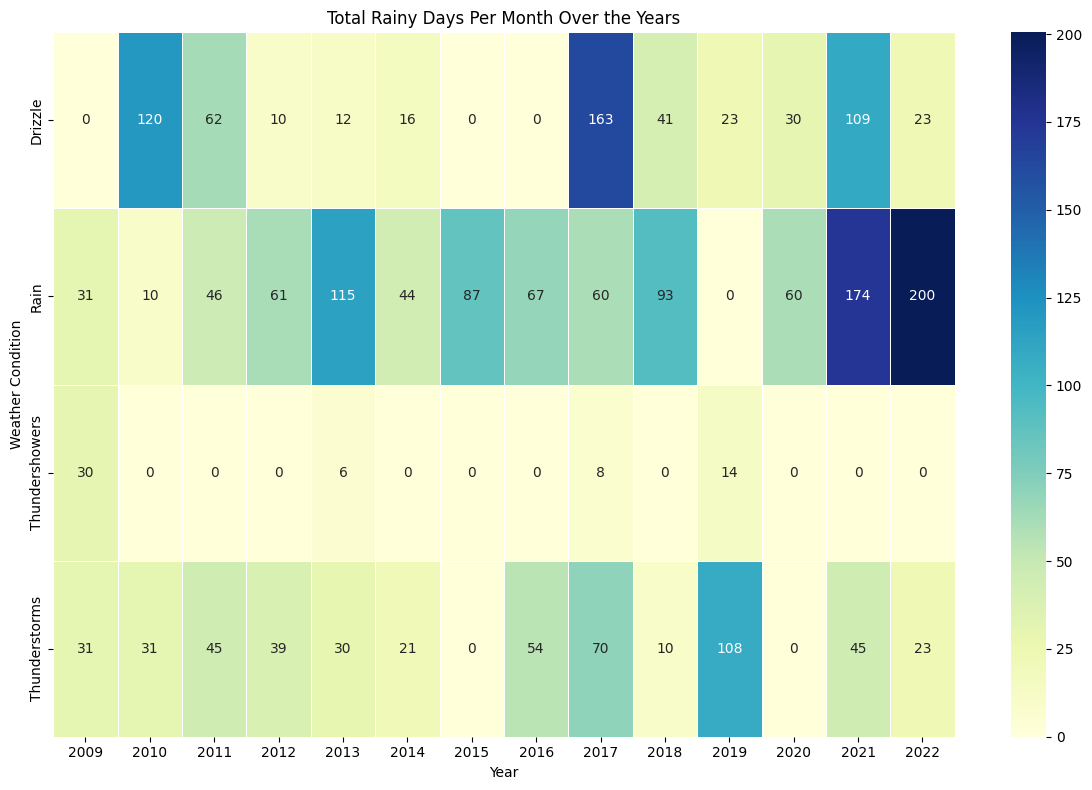

In [ ]:
# Define the weather conditions indicating rainy days
rainy_conditions = ['Rain', 'Thunderstorms', 'Drizzle', 'Thundershowers']

# Initialize an empty list to store the results
monthly_rainy_days = []

# Iterate over each rainy condition
for condition in rainy_conditions:
    # Filter the DataFrame for the current condition and extract month and year
    rainy_data = df[df['weather'].str.contains(condition, case=False)]
    monthly_rainy_days.append(rainy_data.groupby([rainy_data['date'].dt.year, rainy_data['date'].dt.month]).size())

# Combine the results
combined_rainy_days = pd.concat(monthly_rainy_days, axis=1, keys=rainy_conditions).fillna(0).astype(int)

# Pivot the DataFrame to have years as index, months as columns, and total rainy days as values
rainy_days_pivot = combined_rainy_days.pivot_table(index=None, columns='date', values=rainy_conditions, fill_value=0)

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(rainy_days_pivot, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5)
plt.title('Total Rainy Days Per Month Over the Years')
plt.xlabel('Year')
plt.ylabel('Weather Condition')
plt.tight_layout()
plt.show()

In [ ]:
# Print the total rainy days per month over the years
print(combined_rainy_days)

           Rain  Thunderstorms  Drizzle  Thundershowers
date date                                              
2009 12      62             62        0              31
2010 1       31              0        0               0
2011 5       93              0      124               0
2012 2       58            116        0               0
     3      124              0        0               0
2013 4      120              0       60               0
     5       31              0        0               0
     8       93              0        0               0
     11     330            120        0               0
2014 2       84             84        0               0
     11      90              0        0               0
2015 1       62              0        0               0
     3       93              0        0               0
     5      124              0        0               0
     8       31              0        0               0
     10     124              0        0         

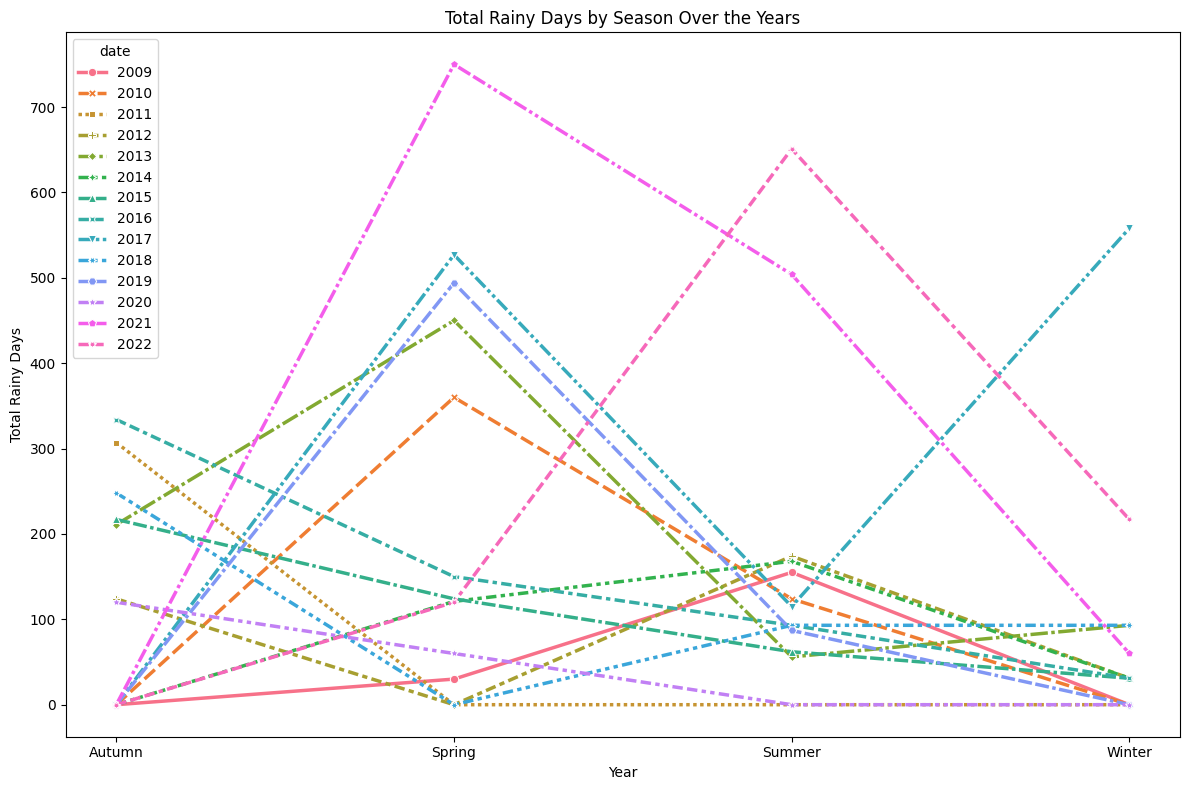

In [ ]:
# Define seasons based on months, considering Southern Hemisphere seasons
def get_season(month):
    if month in [9, 10, 11]:
        return 'Spring'
    elif month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    else:
        return 'Winter'

# Extract month from the date and map months to seasons without modifying the original DataFrame
seasonal_rainy_days = df.assign(
    month=lambda x: x['date'].dt.month,
    season=lambda x: x['date'].dt.month.apply(get_season)
)

# Filter out non-rainy days
seasonal_rainy_days = seasonal_rainy_days[seasonal_rainy_days['weather'].str.contains('Rain|Thunderstorms|Drizzle|Thundershowers', case=False)]

# Group by season and year, count rainy days
seasonal_rainy_days = seasonal_rainy_days.groupby([seasonal_rainy_days['season'], seasonal_rainy_days['date'].dt.year]).size().unstack().fillna(0).astype(int)

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(data=seasonal_rainy_days, markers=True, linewidth=2.5)
plt.title('Total Rainy Days by Season Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Rainy Days')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate summary statistics for each season
seasonal_summary = seasonal_rainy_days.groupby('season').agg(['count', 'mean', 'std', 'min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), 'max']).T

# Display the summary statistics
print(seasonal_summary)


season           Autumn  Spring  Summer  Winter
date                                           
2009 count          1.0     1.0     1.0     1.0
     mean           0.0    30.0   155.0     0.0
     std            NaN     NaN     NaN     NaN
     min            0.0    30.0   155.0     0.0
     <lambda_0>     0.0    30.0   155.0     0.0
     median         0.0    30.0   155.0     0.0
     <lambda_1>     0.0    30.0   155.0     0.0
     max            0.0    30.0   155.0     0.0
2010 count          1.0     1.0     1.0     1.0
     mean           0.0   360.0   124.0     0.0
     std            NaN     NaN     NaN     NaN
     min            0.0   360.0   124.0     0.0
     <lambda_0>     0.0   360.0   124.0     0.0
     median         0.0   360.0   124.0     0.0
     <lambda_1>     0.0   360.0   124.0     0.0
     max            0.0   360.0   124.0     0.0
2011 count          1.0     1.0     1.0     1.0
     mean         307.0     0.0     0.0     0.0
     std            NaN     NaN     NaN 

# D. Are there any trends in temperature changes over the years, and are there periods of unusually high or low temperatures?

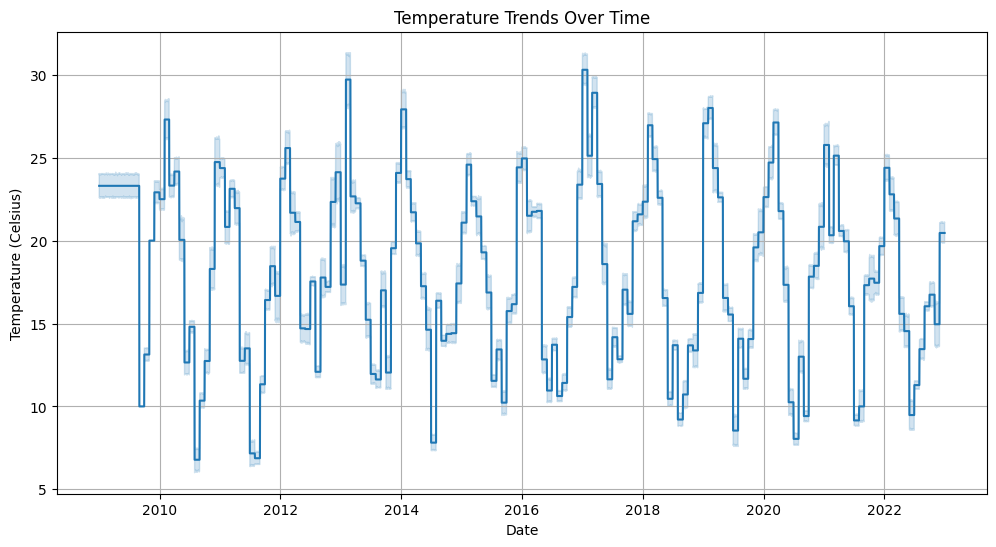

In [ ]:
# Calculate summary statistics
summary_statistics = df['temperature_celsius'].describe()

# Visualize temperature trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='temperature_celsius')
plt.title('Temperature Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid(True)
plt.show()

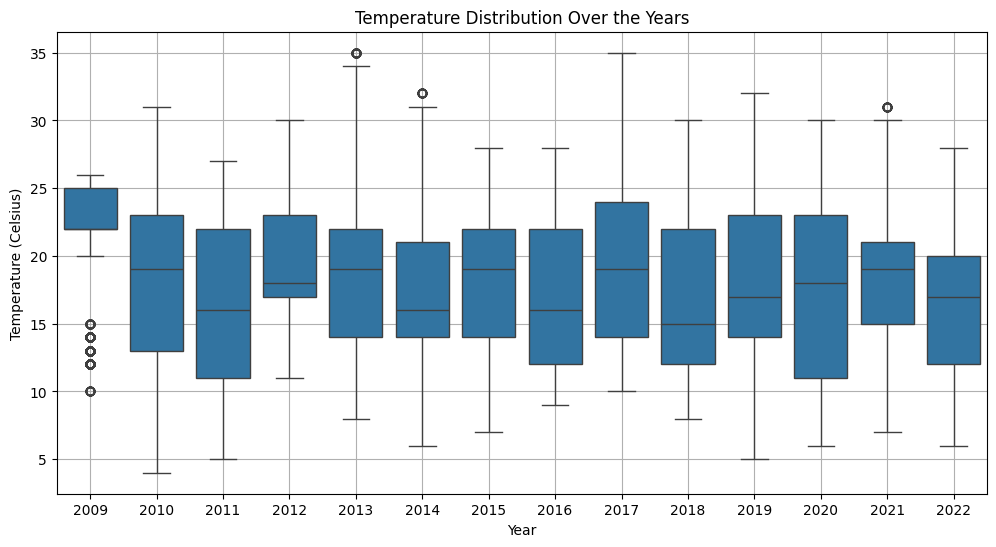

In [ ]:
# Visualize temperature distribution over the years
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=df['date'].dt.year, y='temperature_celsius')
plt.title('Temperature Distribution Over the Years')
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.grid(True)
plt.show()

In [ ]:
# Table with Summary Statistics
summary_statistics_df = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Std Dev', 'Min', '25%', 'Median', '75%', 'Max'],
    'Value': [
        summary_statistics['count'],
        summary_statistics['mean'],
        summary_statistics['std'],
        summary_statistics['min'],
        summary_statistics['25%'],
        summary_statistics['50%'],
        summary_statistics['75%'],
        summary_statistics['max']
    ]
})
print("Summary Statistics for Temperature:")
print(summary_statistics_df)

Summary Statistics for Temperature:
  Statistic          Value
0     Count  122256.000000
1      Mean      18.070344
2   Std Dev       5.734145
3       Min       4.000000
4       25%      14.000000
5    Median      18.000000
6       75%      22.000000
7       Max      35.000000


# Exploring Correlations

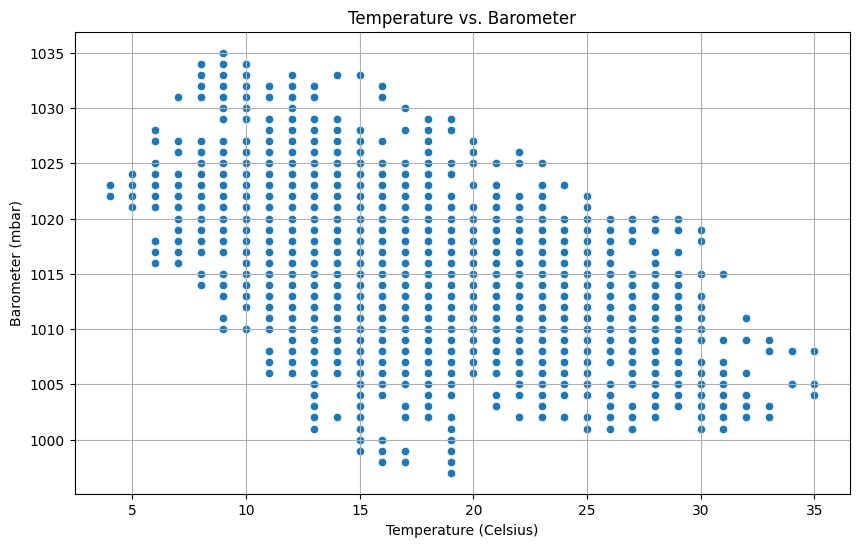

In [ ]:
# Scatter plot of Temperature vs. Barometer
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='temperature_celsius', y='barometer_mbar')
plt.title('Temperature vs. Barometer')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Barometer (mbar)')
plt.grid(True)
plt.show()

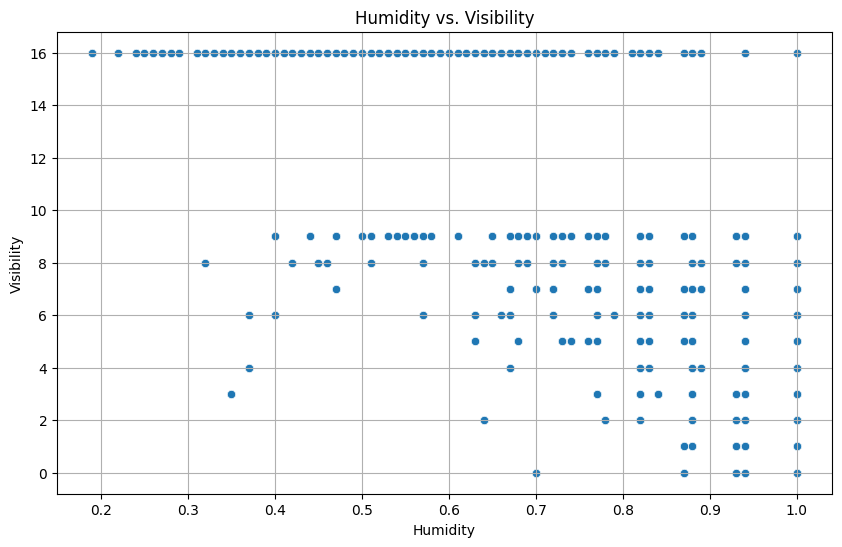

In [ ]:
# Scatter plot of Humidity vs. Visibility
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='humidity', y='visibility')
plt.title('Humidity vs. Visibility')
plt.xlabel('Humidity')
plt.ylabel('Visibility')
plt.grid(True)
plt.show()

In [ ]:
# Table with Correlation Coefficients
correlation_df = df[['temperature_celsius', 'barometer_mbar', 'humidity', 'visibility']].corr()
print("Correlation Matrix:")
print(correlation_df)

Correlation Matrix:
                     temperature_celsius  barometer_mbar  humidity  visibility
temperature_celsius             1.000000       -0.512915 -0.242932    0.266585
barometer_mbar                 -0.512915        1.000000 -0.134563    0.151460
humidity                       -0.242932       -0.134563  1.000000   -0.585548
visibility                      0.266585        0.151460 -0.585548    1.000000
